<a href="https://colab.research.google.com/github/askmuhsin/weights_heist_eva7/blob/main/S4/part_2/rewritten_nn_with_higher_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.bn1 = nn.BatchNorm2d (16)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d (32)
        self.do1 = nn.Dropout2d (0.1)
        self.red = nn.Conv2d(32, 10, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(10, 16, 3)
        self.bn3 = nn.BatchNorm2d (16)
        self.conv4 = nn.Conv2d(16, 16, 3)
        self.bn4 = nn.BatchNorm2d (16)
        self.do2 = nn.Dropout2d (0.1)
        self.conv5 = nn.Conv2d(16, 16, 3)
        self.bn5 = nn.BatchNorm2d (16)
        self.do3 = nn.Dropout2d (0.1)
        self.conv6 = nn.Conv2d(16, 32, 3)
        self.bn6 = nn.BatchNorm2d (32)
        self.gap = nn.AvgPool2d (4)
        self.fc = nn.Linear (32, 10)
        
    def forward(self, x):
        
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.red(x)
        x = self.do1(self.pool1(x))     
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.do2(self.bn4(F.relu(self.conv4(x))))
        x = self.do3(self.bn5(F.relu(self.conv5(x))))
        x = self.bn6(F.relu(self.conv6(x)))
        x = self.gap(x)
        x = x.view(-1, 32)
        x = self.fc (x)

        return F.log_softmax(x)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
            Conv2d-3           [-1, 32, 24, 24]           4,640
       BatchNorm2d-4           [-1, 32, 24, 24]              64
            Conv2d-5           [-1, 10, 24, 24]             330
         MaxPool2d-6           [-1, 10, 12, 12]               0
         Dropout2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,456
       BatchNorm2d-9           [-1, 16, 10, 10]              32
           Conv2d-10             [-1, 16, 8, 8]           2,320
      BatchNorm2d-11             [-1, 16, 8, 8]              32
        Dropout2d-12             [-1, 16, 8, 8]               0
           Conv2d-13             [-1, 16, 6, 6]           2,320
      BatchNorm2d-14             [-1, 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:

torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    graph['test_loss'].append (test_loss)
    graph['test_acc'].append (correct * 100. / len (test_loader.dataset))

In [6]:
model = Net().to(device)
graph = {
    'train_loss' : [],
    'train_acc' : [],
    'test_loss' : [],
    'test_acc' : []
}
optimizer = optim.Adam (model.parameters (), lr = 0.001)
for epoch in range(1, 21):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

loss=0.05546095594763756 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]



Test set: Average loss: 0.0556, Accuracy: 9852/10000 (99%)



loss=0.08314317464828491 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]



Test set: Average loss: 0.0384, Accuracy: 9881/10000 (99%)



loss=0.020435264334082603 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]



Test set: Average loss: 0.0297, Accuracy: 9908/10000 (99%)



loss=0.08419910073280334 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]



Test set: Average loss: 0.0291, Accuracy: 9909/10000 (99%)



loss=0.02977217733860016 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]



Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99%)



loss=0.06597314774990082 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]



Test set: Average loss: 0.0248, Accuracy: 9911/10000 (99%)



loss=0.044931989163160324 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]



Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99%)



loss=0.005989477038383484 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]



Test set: Average loss: 0.0246, Accuracy: 9918/10000 (99%)



loss=0.04723896086215973 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]



Test set: Average loss: 0.0222, Accuracy: 9928/10000 (99%)



loss=0.010276301763951778 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]



Test set: Average loss: 0.0229, Accuracy: 9923/10000 (99%)



loss=0.00977571215480566 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.82it/s]



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99%)



loss=0.021006420254707336 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]



Test set: Average loss: 0.0282, Accuracy: 9922/10000 (99%)



loss=0.016887472942471504 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s]



Test set: Average loss: 0.0230, Accuracy: 9924/10000 (99%)



loss=0.002366029191762209 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]



Test set: Average loss: 0.0260, Accuracy: 9913/10000 (99%)



loss=0.0026819256599992514 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]



Test set: Average loss: 0.0247, Accuracy: 9920/10000 (99%)



loss=0.0022785754408687353 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]



Test set: Average loss: 0.0230, Accuracy: 9936/10000 (99%)



loss=0.032711904495954514 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]



Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99%)



loss=0.012338931672275066 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]



Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99%)



loss=0.019424546509981155 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]



Test set: Average loss: 0.0223, Accuracy: 9938/10000 (99%)



loss=0.018911611288785934 batch_id=468: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]



Test set: Average loss: 0.0244, Accuracy: 9927/10000 (99%)



In [7]:
import matplotlib.pyplot as plt

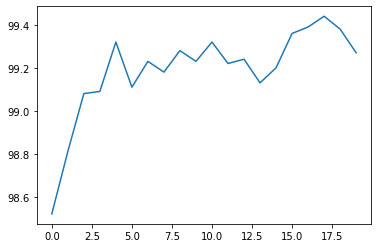

In [13]:
plt.plot(graph['test_acc'])

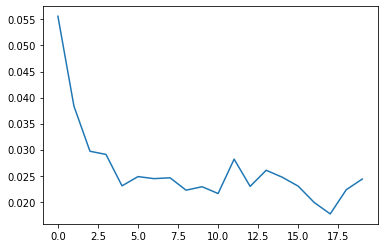

In [14]:
plt.plot(graph['test_loss'])